In [1]:
import sys
from pathlib import Path
import logging
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

# --- Setup Logging and Paths ---
logging.basicConfig(level=logging.INFO, filename='notebook.log', filemode='w')
logger = logging.getLogger(__name__)

project_root = Path('.').resolve()
src_path = project_root / 'layered-context-graph' / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
logger.info(f"Project root set to: {project_root}")

from models.baai_model import BAAIModel
from models.qwq_model import QwQModel
from partitioning.partition_manager import PartitionManager

In [2]:
# --- Cell 2: Model Initialization ---
BAAI_MODEL_PATH = './bge-en-icl'
QWQ_MODEL_PATH = './QwQ_LCoT_7B_Instruct/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Initializing BAAIModel (lazy)...")
embedding_model = BAAIModel(model_path=BAAI_MODEL_PATH, device=device)
print("BAAIModel initialized.")

print("Initializing QwQModel (lazy)...")
segmenter_model = QwQModel(qwq_model_path=QWQ_MODEL_PATH, device=device)
print("QwQModel initialized.")

Initializing BAAIModel (lazy)...
BAAIModel initialized.
Initializing QwQModel (lazy)...
QwQModel initialized.


In [3]:
# --- Cell 3: End-to-End Partition and Graph Test ---
start_time = time.time()
pipeline_text = open('Layer_Context_Window_Graphs', 'r').read() if Path('Layer_Context_Window_Graphs').exists() else "The sun rises in the east. Birds sing. Later, the topic shifts to astrophysics. The lifecycle of a star is complex. Returning to our original theme, the weather is warm."
segmentation_rule = "Split into paragraphs."

# 1. Initialize the manager
manager = PartitionManager(similarity_threshold=0.7)
manager.initialize_graph(pipeline_text)

# 2. Perform segmentation
print(f"Applying Rule: '{segmentation_rule}'")
segmentation_start = time.time()
leaves_to_process = manager.get_leaves_to_process()
for segment_to_split in leaves_to_process:
    new_content_pieces = embedding_model.segment(segmentation_rule, segment_to_split.content)
    manager.add_child_segments(segment_to_split.id, new_content_pieces)
segmentation_end = time.time()
print(f"Segmentation took {segmentation_end - segmentation_start:.2f} seconds.")

# 3. Add semantic edges
embedding_start = time.time()
segments_for_embedding = manager.get_all_segments_for_embedding()
contents = [seg['content'] for seg in segments_for_embedding]
embeddings = embedding_model.encode(contents, batch_size=32)
for i in range(len(segments_for_embedding)):
    for j in range(i + 1, len(segments_for_embedding)):
        similarity = np.dot(embeddings[i], embeddings[j])
        manager.add_edges_from_similarity(segments_for_embedding[i]['id'], segments_for_embedding[j]['id'], similarity)
embedding_end = time.time()
print(f"Embedding and edge creation took {embedding_end - embedding_start:.2f} seconds.")

# 4. Classify nodes
classification_start = time.time()
manager.classify()
classification_end = time.time()
print(f"Classification took {classification_end - classification_start:.2f} seconds.")

end_time = time.time()
print(f"\nGraph construction complete. Found {len(manager.segments)} nodes and {manager.graph.number_of_edges()} edges.")
print(f"Total pipeline time: {end_time - start_time:.2f} seconds.")

Applying Rule: 'Split into paragraphs.'
Model device: meta
Model device after loading: cuda:0
Segmentation took 66.25 seconds.
Embedding and edge creation took 2.38 seconds.
Classification took 0.01 seconds.

Graph construction complete. Found 31 nodes and 80 edges.
Total pipeline time: 68.65 seconds.


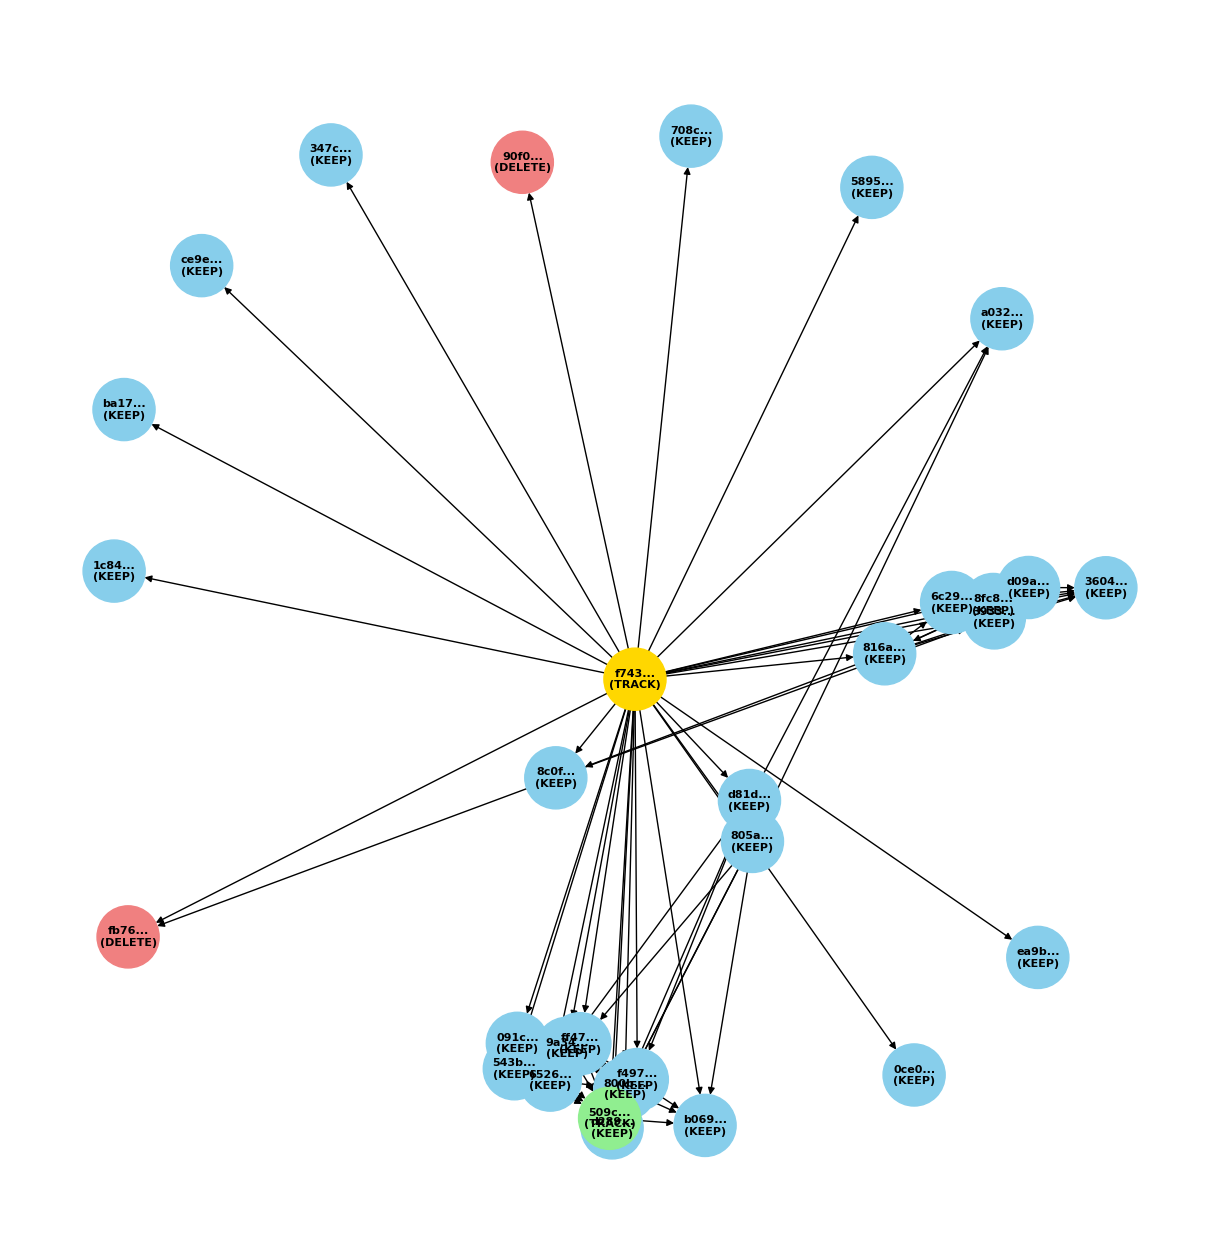

In [4]:
# --- Cell 4: Visualize the Graph ---
graph = manager.graph
if graph and graph.nodes():
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(graph, seed=42)
    
    labels = {node_id: f"{data['segment'].id[:4]}...\n({data['segment'].tag})" for node_id, data in graph.nodes(data=True)}
    
    color_map = {'KEEP': 'skyblue', 'TRACK': 'lightgreen', 'DELETE': 'lightcoral'}
    if manager.root_id in graph.nodes:
        graph.nodes[manager.root_id]['segment'].tag = 'ROOT'
        color_map['ROOT'] = 'gold'
        
    node_colors = [color_map.get(data['segment'].tag, 'gray') for _, data in graph.nodes(data=True)]

    nx.draw(graph, pos, labels=labels, with_labels=True, node_size=2000, node_color=node_colors, font_size=8, font_weight='bold')
    plt.title('Knowledge Graph from PartitionManager')
    plt.show()
else:
    print("No graph data to visualize.")

In [5]:
# --- Cell 5: Print Deleted Segments ---
print("--- Segments Marked for Deletion ---")
deleted_segments = [seg for seg in manager.segments.values() if seg.tag == 'DELETE']

if deleted_segments:
    for i, segment in enumerate(deleted_segments):
        print(f"--- Deleted Segment {i+1} (ID: {segment.id}) ---")
        print(segment.content)
        print("-" * 40)
else:
    print("No segments were marked for deletion.")

--- Segments Marked for Deletion ---
--- Deleted Segment 1 (ID: 90f0d77f-82d7-4972-b465-4e9dd7e99153) ---
**Attention head manipulation** through instructional seeding

The key insights from the document:

## Graph-Theoretic Foundation
- Your partitions would have **15-30% overlap** to hit the percolation threshold
- This creates both **local coherence** and **global connectivity**
- Small-world network properties emerge naturally

## Practical Implementation
The most actionable approach seems to be:
1. **Seed instructions** throughout text (like `<MATH>`, `<DIALOGUE>`, `<TRACK>`)
2. Use **attention patterns** to recover/reinforce these partitions
3. Let the **LLM classify chunks** as KEEP/DELETE/TRACK
4. Build a **graph structure** where edges represent semantic relationships

## The "Fuzzy Pipeline"
Your system would essentially create:
- **Working memory** (active context)
- **Archive memory** (kept chunks)
- **Pending threads** (tracked items)
- All connected via a percolation-enab